University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2022  
Luigi Acerbi

# Week 4 exercises

## 1. MCMC convergence diagnostics (4 pts)

The file loaded below contains samples from 3 chains of Metropolis-Hastings sampling for the bimodal target 
$$\pi^*(\theta) = \exp(-\gamma (\theta^2-1)^2)$$
with $\gamma = 4$. Warm-up samples have already been removed from the saved results, so you do not need to remove warm-up samples.

1. Evaluate the $\hat{R}$-statistic defined in Sec. 8.1.1 of the course notes using the original 3 chains. Report your result in Moodle.
2. Evaluate the split-$\hat{R}$ (see Sec. 8.1.1) by splitting the chains in half to obtain 6 chains. Report your result in Moodle.
3. Compute the effective sample size (ESS) for the first chain (1000 samples), when we know the estimates $\mu = 0$, $\sigma^2 = 0.9185$ from an independent long simulation. Use the truncated sum estimate from Sec. 8.1.2 of the course notes. Report your result in Moodle.
   *Hint*:  Use Eqs. 8.1 and 8.4, for which you will have to find the upper bound $K$ of the sum as indicated.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.distributions import rv_frozen
from typing import Callable
from scipy import stats

plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style('whitegrid')

samples = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/bimod_samples.txt', header=None, sep='\t').values

# 1.1

def compute_B(samples: np.ndarray) -> float:
    n, m = samples.shape
    scalar = n / (m - 1)
    return scalar * np.sum([(np.mean(samples[:, j], axis=0) - np.mean(samples))**2 for j in range(m) ])


def compute_W(samples: np.ndarray) -> float:
    def compute_S(j: int) -> float:
        return np.mean((samples[:, j] - samples[:, j].mean())**2)
    _, m = samples.shape
    return np.mean([compute_S(j) for j in range(m)])

def rhat(samples: np.ndarray) -> float:
    n, _ = samples.shape
    w = compute_W(samples)
    b = compute_B(samples)

    var = ((n-1)/n) * w + (1/n) * b
    return np.sqrt(var / w)

print(samples.shape)
print(rhat(samples))


(1000, 3)
1.02592438270425


In [ ]:
split_samples = np.zeros((500, 6))
split_samples[:, 0] = samples[:500, 0]
split_samples[:, 1] = samples[500:, 0]
split_samples[:, 2] = samples[:500, 1]
split_samples[:, 3] = samples[500:, 1]
split_samples[:, 4] = samples[:500, 2]
split_samples[:, 5] = samples[500:, 2]


assert not np.equal(0, split_samples).any()

In [ ]:
def split_rhat(samples: np.ndarray) -> float:
    n, m = samples.shape
    assert n > m, "Expect shape (samples, chains)"
    split_at = n // 2
    split_samples = np.zeros((split_at, m*2))
    # do the split
    for i in range(0, split_samples.shape[1]):
        if i % 2 == 0:
            split_samples[:, i] = samples[split_at:, i//2]
        else:
            split_samples[:, i] = samples[:split_at, i//2]
    return rhat(split_samples)

In [ ]:
# 1.2
print(split_samples.shape)
print(rhat(split_samples))

In [ ]:
# 1.3

from typing import Iterator


mu = 0
sigma_sq = .9185
first_chain = samples[:, 0]
assert first_chain.shape == (1000,)

def compute_rho(samples: np.ndarray, k: int, mu: float = mu, sigma_sq: float = sigma_sq) -> float:
    rho_i = 0
    for i in range(samples.shape[0] - k):
        rho_i += (samples[i] - mu) * (samples[i+k] - mu)
    return rho_i * (1 / (samples.shape[0] * sigma_sq))

def find_k_upper_bound(samples: np.ndarray, k: int) -> int:
    i = 0
    max_iterations = 1000
    k = 0
    while True:
        rho_k_plus_1 = compute_rho(samples, k+1)
        rho_k_plus_2 = compute_rho(samples, k+2)
        if np.sum(rho_k_plus_1 + rho_k_plus_2) < 0 and k % 2 == 1:
            break
        k += 1
        i += 1
        if i > max_iterations:
            raise ValueError('Max iterations reached')
    return k
k = find_k_upper_bound(first_chain, 0)
print(f"Upper bound for k: {k}")

M = first_chain.shape[0]
ESS = M / (1 + (2 * np.sum([compute_rho(first_chain, k) for k in range(1, k+1)])))
print(ESS)


## 2. MCMC sampling for a Bayesian regression model (6 pts)

In this task we will apply MCMC sampling to a linear regression model that predicts the birth weight ('bwt', $y_i$) for old mothers (age >= 30) as a function of the age of the mother, duration of the pregnancy and weight of the mother ('age', 'gestation', 'weight'; $\mathbf{x}_i$).

As our model we will consider a linear regression model fitted to the observations $((\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \dots, (\mathbf{x}_n, y_n))$. The code below will load the matrix `x` (each row is one sample) and vector `y`. The values $\mathbf{x}_1, \dots, \mathbf{x}_n$ are the *input values* and $y_1, \dots, y_n$ are the *target values*. The loading code normalises all data to have zero mean and unit variance to get the regression coefficients to a shared scale.

We model the data with a linear regression model
$$ y_i = \mathbf{x}_i \boldsymbol{\beta} + \epsilon_i, $$
where $\mathbf{x}_i$ is a row vector of input values, $\boldsymbol{\beta} = (\beta_1, \beta_2, \beta_3)^T$ is a column vector of regression coefficients and $\epsilon_i$ is a Gaussian noise term $\epsilon_i \sim \mathcal{N}(0, \sigma_x^2)$.

The likelihood of the model is
$$ p(Y \mid X, \beta, \sigma_x) = \prod_{i=1}^n \mathcal{N}(y_i; \mathbf{x}_i \boldsymbol{\beta}, \sigma_x^2). $$

The regression coefficients $\beta_j$ have a hierarchical prior
$$ p(\beta_j | \sigma_{\beta}) = \mathcal{N}(\beta_j;\; 0, \sigma_{\beta}^2), \quad j = 1, 2, 3, $$
with standard deviation $\sigma_{\beta}$.
Its prior is
$$ p(\sigma_{\beta}) = \mathrm{Gamma}(k_{\beta} = 2, \theta_{\beta} = 1/2) $$
with shape $k_{\beta}=2$ and scale $\theta_{\beta} = 1/2$.
The prior of the noise standard deviation $\sigma_x$ is
$$ p(\sigma_{x}) = \mathrm{Gamma}(k_{x} = 2, \theta_{x} = 1/2) $$
with shape $k_{x}=2$ and scale $\theta_{x} = 1/2$.
As usual, we assume the prior factorizes as $p(\sigma_\beta, \sigma_x) = p(\sigma_\beta) p(\sigma_x)$.

To ensure the standard deviations are positive, express them as $\sigma_{\beta} = \exp(s_{\beta})$ and $\sigma_x = \exp(s_x)$. Remember to apply the density transformation to transform the priors over $\sigma_{\beta}$ and $\sigma_x$ to those over $s_{\beta}$ and $s_x$!

The full set of model parameters for MCMC is thus $\theta = (s_{\beta}, s_x, \beta_1, \beta_2, \beta_3)$.

Write a Metropolis-Hastings MCMC sampler to sample from the joint posterior distribution of all model parameters $\theta$, $$p(\theta \mid X, Y) = p(s_{\beta}, s_x, \beta_1, \beta_2, \beta_3 \mid X, Y).$$

1. Implement a Metropolis-Hastings MCMC sampler with proposal $q(\theta' ; \theta) = \mathcal{N}(\theta';\; \theta, 0.04^2 \mathbf{I})$, i.e. a multivariate normal proposal centred around the current state with standard deviation 0.04 for each component.
2. Run the sampler for 5000 iterations starting from each of the 4 initial points defined by the columns of `inits`. Discard the first 2500 iterations for each run as warm-up. Compute the split-$\hat{R}$ statistic for the samples of $\theta$. Report the largest split-$\hat{R}$ over different components to Moodle.
3. Check which variable is having convergence issues. Increase the proposal standard deviation for that component to 0.4 while keeping the proposals for the other components the same. Repeat the sampling as above and report the largest split-$\hat{R}$ over different components to Moodle.
4. Report the posterior mean of the log-standard deviation $s_{\beta}$ obtained from combining all the 10000 retained samples from the latter sampler to Moodle.

*Notes*: 
- Please note that all computations and results are based on the unbounded variables $s_{\beta}$ and $s_x$. For the purpose of this exercise, there is no need to transform anything back to the original space of $\sigma_{\beta}$ and $\sigma_x$.
- The [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) has two common representations, one in terms of shape and scale parameters ($k$ and $\theta$) and one in terms of shape and rate parameters ($\alpha$ and $\beta$). Please check that you are using the correct one.

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy import stats

# Load the data set
babies_full = pd.read_csv("https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/babies2.txt", sep='\t')

# Pick a subset
babies = babies_full.loc[(babies_full['age']>=30).values,:]

x = babies[['age', 'gestation', 'weight']].values.astype(float)
y = babies[['bwt']].values.astype(float).squeeze()

# Remove mean from inputs
x -= np.mean(x, 0)
# Standardise input variance
x /= np.std(x, 0)

# Remove mean from outputs
y -= np.mean(y, 0)
# Standardise output variance
y /= np.std(y, 0)

inits = np.array([[ 1.67272789, -0.02134183, -0.78116796, -1.77420787],
                  [-0.6030697,   0.4464263,   0.3627991,  -0.7342916 ],
                  [-1.32685026, -0.37427079, -0.06744599,  0.21175491],
                  [ 0.87702047, -0.54171875, -0.44736686, -2.39045985],
                  [ 1.00631791, -1.34638203, -0.40343913, -0.64535026]])

#print(x)
#print(y)

In [ ]:

from typing import Callable

rng = npr.default_rng(1234)

def log_sigma_beta_prior(sigma: float) -> float:
    return stats.gamma(a=2, scale=1/2).logpdf(sigma)

def log_sigma_x_prior(sigma: float) -> float:
    return stats.gamma(a=2, scale=1/2).logpdf(sigma)

def log_beta_prior(beta: np.ndarray, sigma: float) -> float:
    return stats.norm(0, sigma).logpdf(beta)

def log_likelihood(y: float, xi: np.ndarray, beta: np.ndarray, sigma: np.ndarray) -> float:
    # should this me a multi-dimensional normal, or X draws from a normal?
    return np.sum(stats.norm(xi @ beta, sigma).logpdf(y))

def log_factorised_prior(beta: np.ndarray, sigma_beta: float, sigma_x: float) -> float:
    # sigma_x and sigma_x have been transformed by exp to ensure they are positive
    return np.sum(log_sigma_beta_prior(sigma_beta) + log_sigma_x_prior(sigma_x) + log_beta_prior(beta, sigma_beta))

def log_posterior(theta: np.ndarray, y: float, xi: np.ndarray) -> float:
    s_beta = theta[0]
    s_x = theta[1]
    sigma_beta = np.exp(s_beta)
    sigma_x = np.exp(s_x)
    beta = theta[2:]
    prior = log_factorised_prior(beta, sigma_beta, sigma_x) + s_beta + s_x
    lh = log_likelihood(y, xi, beta, sigma_x)
    posterior = prior + lh
    print(f"prior: {np.exp(prior)}, likelihood: {np.exp(lh)}")
    return posterior


def metropolis_hastings(theta0: np.ndarray, 
                        n: int, 
                        log_target: Callable[..., np.ndarray], 
                        proposal: Callable[..., np.ndarray],
                        ) -> tuple[np.ndarray, float]:
    theta = theta0
    samples_3_1 = np.zeros(shape=(n, theta0.shape[0]))
    accepts = 0
    for i in range(n):
        theta_prop = proposal(theta)
        u = rng.uniform(size=theta0.shape[0])
        x = log_target(theta_prop) - log_target(theta)
        if (np.log(u) < x).all() :
            theta = theta_prop
            accepts += 1
        samples_3_1[i] = theta
    return samples_3_1, accepts / n


def proposal(theta: np.ndarray) -> np.ndarray:
    s = np.eye(theta.shape[0]) *(.04)
    return rng.multivariate_normal(theta, s**2)

def modified_proposal(theta: np.ndarray) -> np.ndarray:
    s = np.eye(theta.shape[0]) *(.04)
    s[0, 0] = 0.4
    return rng.multivariate_normal(theta, s**2)

In [ ]:
n_samples = 5000
n_params, n_chains,  = inits.shape
chains = np.zeros(( n_samples//2, n_chains, n_params))
for chain in range(n_chains):
    samples_3_1, acceptance_rate = metropolis_hastings(
        theta0=inits[:,chain],
        n=5000,
        log_target=lambda theta: log_posterior(theta, y, x),
        proposal=proposal,
    )
    chains[:, chain, :] = samples_3_1[n_samples//2:]
    print(f'Chain {chain+1} acceptance rate: {acceptance_rate}')


In [ ]:
s_beta_chains, s_x_chains = chains[:, :, 0], chains[:, :, 1]
beta0_chains, beta1_chains, beta2_chains, = chains[:, :, 2], chains[:, :, 3], chains[:, :, 4]

In [ ]:
print(
    rhat(s_beta_chains),
    rhat(s_x_chains),
    rhat(beta0_chains),
    rhat(beta1_chains),
    rhat(beta2_chains),
)

In [ ]:
print(
    split_rhat(s_beta_chains),
    split_rhat(s_x_chains),
    split_rhat(beta0_chains),
    split_rhat(beta1_chains),
    split_rhat(beta2_chains),

)

In [ ]:
n_samples = 5000
n_params, n_chains,  = inits.shape
chains_2 = np.zeros(( n_samples//2, n_chains, n_params))
for chain in range(n_chains):
    samples_3_2, acceptance_rate = metropolis_hastings(
        theta0=inits[:,chain],
        n=5000,
        log_target=lambda theta: log_posterior(theta, y, x),
        proposal=modified_proposal,
    )
    chains_2[:, chain, :] = samples_3_2[n_samples//2:]
    print(f'Chain {chain+1} acceptance rate: {acceptance_rate}')


In [ ]:
s_beta_chains, s_x_chains = chains_2[:, :, 0], chains_2[:, :, 1]
beta0_chains, beta1_chains, beta2_chains, = chains_2[:, :, 2], chains_2[:, :, 3], chains_2[:, :, 4]

In [ ]:
np.array([
    split_rhat(s_beta_chains),
    split_rhat(s_x_chains),
    split_rhat(beta0_chains),
    split_rhat(beta1_chains),
    split_rhat(beta2_chains),
])

In [ ]:
sigma_beta_posterior = s_beta_chains.flatten()
assert sigma_beta_posterior.shape == (10000, )
sns.displot(sigma_beta_posterior, kde=True)
print(sigma_beta_posterior.mean())
#-0.8996576580619626

## 3. Importance sampling (4 pts)

Develop an importance sampler for the bimodal target
$$\pi(\theta) = \sum_{i=1}^2 p_i \mathcal{N}(\theta ; \mu_i, \sigma_i^2),$$
where $p_1 = p_2 = 1/2$ and $\mu_1 = -1, \mu_2 = 1$.
Use $\mathrm{Laplace}(0, b)$ with a suitable $b$ as the proposal and evaluate the expectation $\mathbb{E}[(\theta-1)^2]$ when
1. $\sigma_1^2 = \sigma_2^2 = 0.5$.
2. $\sigma_1^2 = \sigma_2^2 = 0.1$.

The required tolerance for the answer is $\pm 0.1$.

In order to estimate the accuracy of your answer, it is recommended to run the sampler a few times and compute the standard deviation of the values you obtain. Monte Carlo error scales as $1/\sqrt{n}$ with the number of iterations $n$.

In [ ]:
import numpy as np
from scipy import stats

LAPLACE_LOC = 0


def sample_laplace_proposal(b: float) -> np.ndarray:
    return stats.laplace.rvs(loc=LAPLACE_LOC, scale=b)

def pdf_laplace_proposal(x: float, b: float) -> float:
    return stats.laplace.pdf(x, loc=LAPLACE_LOC, scale=b)


def pi_of_theta(theta: np.ndarray, p: np.ndarray, mu: float, sigma_sq: float) -> float:
    return np.sum( np.exp(np.log(p) + stats.norm(mu, np.sqrt(sigma_sq)).logpdf(theta)))


def e_of_pi_of_theta(theta: np.ndarray) -> float:
    return np.mean((theta - 1)**2)

n_trials = 5
n_samples = 25000


# 3.1
mu = [-1, 1]
p = [0.5, 0.5]


def importance_sample(n_trials: int, n_samples: int, b: float, p: np.ndarray, mu_1: np.ndarray, sigma_sq_1: np.ndarray) -> np.ndarray:
    samples = np.zeros((n_trials, n_samples))
    for i in range(n_trials):
        for j in range(n_samples):
            theta = sample_laplace_proposal(b)
            importance_weight = pi_of_theta(theta, p, mu_1, sigma_sq_1) / pdf_laplace_proposal(theta, b)
            samples[i,j] = e_of_pi_of_theta(theta) * importance_weight
    return samples
    


In [ ]:
sigma_sq_1 = [.5, .5]
b_1 = 1.333

samples_3_1 = importance_sample(5, n_samples, b_1, p, mu, sigma_sq_1)
print(np.var(samples_3_1))
print(np.mean(samples_3_1, axis=1))
print(np.mean(samples_3_1, axis=1).std())
print(np.mean(samples_3_1, axis=1).mean())

In [ ]:
sigma_sq_2 = [.1, .1]
b_2 = 1

samples_3_2 = importance_sample(n_trials, n_samples, b_2, p, mu, sigma_sq_2)
print(np.var(samples_3_2))
print(np.mean(samples_3_2, axis=1))
print(np.mean(samples_3_2, axis=1).std())
print(np.mean(samples_3_2))

In [ ]:
del(samples_3_1, samples_3_2)

## 4. Rejection ABC for a dynamical model (6 pts)

In this task we will develop an ABC sampler for the autoregressive (AR) model:
$$ x_{t+1} = a x_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2). $$
Throughout the exercise, we assume $x_0 = 1$. The model has two parameters, $a$ and $\sigma$. We set priors
$$ p(a) = \mathrm{Uniform}(a;\; 0, 1), \quad p(\sigma) = \mathrm{Gamma}(\sigma;\; k_\sigma, \theta_\sigma) $$
with $k_\sigma = 8, \theta_\sigma = 1/8$. Note that we use the shape/scale parametrisation also used by NumPy and that the prior is over $\sigma$, not $\sigma^2$ (also more consistent with NumPy parametrisation).

1. Implement a function to simulate the AR process. Test your function by generating and plotting two independent realisations of length 200 with $a = 0.75$, $\sigma = 0.2$. Notice how the sequences diverge relatively quickly and are essentially independent toward the end. *Hint*: Length 200 means that the generated sequence will take values $x_0, x_1, \ldots, x_{199}$.
2. Sample 5000 sequences from the AR process of length 200 with $a = 0.75$, $\sigma = 0.2$. For each sequence, extract the last value. Compute the standard deviation of the last values across the 5000 simulated sequences and report it in Moodle.
3. For the purpose of ABC sampling, we are going to summarize the sequences with the 2-dimensional summary statistics
$$ S(X) = \left( \frac{1}{N} \sum_{i=0}^{N-1} x_i^2, \frac{1}{N-1} \sum_{i=0}^{N-2} x_i x_{i+1} \right). $$
Load the the single observed sequence $X$ (the data) with the code below and evaluate $S(X)$ on the provided sequence. Report the two summary statistics of the data in Moodle.

4. Implement an ABC sampler to infer the posterior over $a$ and $\sigma$ given the single observed sequence $X$ loaded below using the simulator implemented above and the 2-dimensional summary statistics defined above. Run your sampler to generate samples with acceptance threshold $\| S(X) - S(X^\star)\|_2 \le \epsilon$ with $\epsilon = 0.2$.
5. Report the approximate posterior means and standard deviations of $a$ and $\sigma$ to Moodle.

The required tolerance on the posterior means and standard deviations is $\pm 0.03$.

*Hints*:
- Note that for the acceptance threshold we are using the standard Euclidean metric: $\|v\|_2 = \sqrt{\sum_{i} v_i^2}$.
- The ABC sampler here can easily require tens of seconds or more when the number of samples is large, so you should be careful when increasing the number of samples. A reasonably good implementation should be able to reach the required accuracy in less than a minute.

In [2]:
import pandas as pd

dataframe = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/ar_time_series_data.txt', header=None, sep='\t')
data = dataframe.values[:,0]

In [3]:
def mcmc_abc(
    a_prior: Callable[[], float],
    sigma_prior: Callable[[], float],
    eps: Callable[[float], float],
    x0: float = 1,
    n_iterations: int = 500,
):
    x = np.zeros(n_iterations)
    x[0] = x0
    for i in range(1, n_iterations):
        sigma_i = sigma_prior()
        coeff = a_prior()
        x_star = (coeff * x[i-1]) + eps(sigma_i)
        x[i] = x_star
    return x

In [4]:
chain_1 = mcmc_abc(
    a_prior = lambda: .75, 
    sigma_prior = lambda : .2, 
    eps = lambda sigma: stats.norm(0, sigma).rvs(),
    x0 = 1,
    n_iterations = 200,
    )

chain_2 = mcmc_abc(
    a_prior = lambda: .75, 
    sigma_prior = lambda : .2, 
    eps = lambda sigma: stats.norm(0, sigma).rvs(),
    x0 = 1,
    n_iterations = 200,
    )

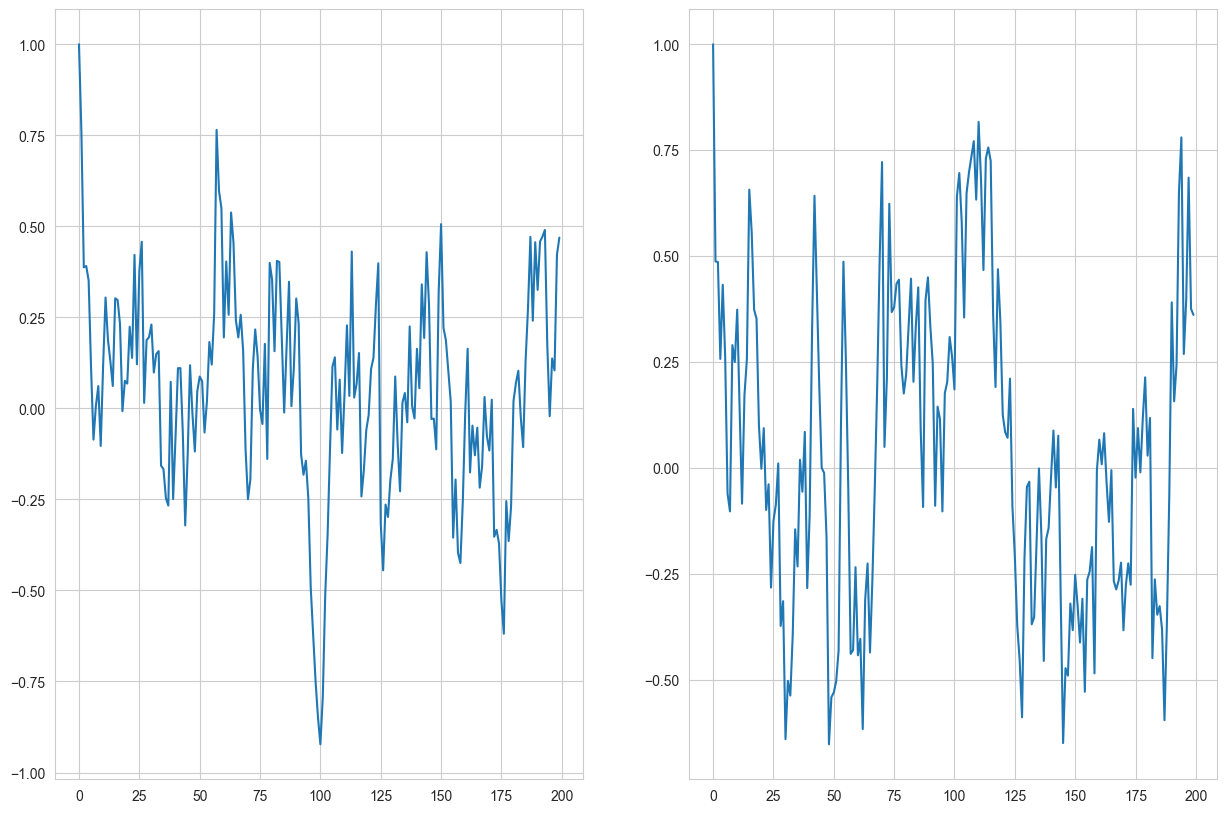

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(chain_1)
ax[1].plot(chain_2)
plt.show()

In [ ]:
final_values = np.zeros(5000)
for i in range(5000):
    x = mcmc_abc(
        a_prior=lambda: .75,
        sigma_prior=lambda: .2,
        eps=lambda sigma: stats.norm(0, sigma).rvs(),
        x0=1,
        n_iterations=200,
    )
    final_values[i] = x[-1]

KeyboardInterrupt: 

KeyboardInterrupt: 

In [7]:
final_values.std()

0.031488620311704185

In [8]:
def S_x(x: np.ndarray) -> np.ndarray:
    N = len(x)
    x1 = np.sum(x**2) / N
    x2 = np.sum(x[:-1] * x[1:]) * (1 / (N-1))
    return np.array([x1, x2])

In [9]:
S_x(data)

array([1.30559239, 1.18492572])

In [10]:
from numpy import random
rng = random.default_rng(1234)

def generate_sequence(
    x0: float,
    alpha:float,
    sigma: float,
    epsilon_t: Callable[[float], float],
    data: np.ndarray,
) -> float:
    n_steps = 20
    x = np.zeros(n_steps)
    x[0] = x0
    eps_samples = epsilon_t(sigma, n_steps)
    x[1:] = (alpha * x[:-1]) + eps_samples[1:]
    return np.linalg.norm(S_x(data)- S_x(x), ord=2)

def abc(
    alpha_prior: Callable[[], float],
    sigma_prior: Callable[[], float],
    epsilon: float,
    sample_target: int = 1000,
) -> np.ndarray:
    params: list[tuple[float, float]] = []
    samples = 0
    while True:
        alpha = alpha_prior()
        sigma = sigma_prior()
        norm = generate_sequence(
            x0=1,
            alpha=alpha,
            sigma=sigma,
            epsilon_t=lambda sigma, n: rng.normal(0, sigma**2, size=n),
            data=data,
        )
        if norm < epsilon:
            print(f"Accepted: {alpha}, {sigma}")
            params.append((alpha, sigma))
            samples += 1
        if samples >= sample_target:    
            break
    return np.array(params)

params = abc(
    alpha_prior=lambda: rng.uniform(0, 1, size=1),
    sigma_prior=lambda: rng.gamma(8, 1/8, size=1),
    epsilon=.2,
    sample_target=5000,
)

Accepted: [0.30682049], [1.08989972]
Accepted: [0.43692286], [0.94914161]
Accepted: [0.68433093], [1.25876224]
Accepted: [0.77665783], [1.25053799]
Accepted: [0.81165161], [1.12233662]
Accepted: [0.59331506], [1.16620754]
Accepted: [0.89880067], [1.07095027]
Accepted: [0.07812942], [1.00812217]
Accepted: [0.12735243], [1.07111302]
Accepted: [0.62252157], [1.3230137]
Accepted: [0.06764925], [1.1660712]
Accepted: [0.86682335], [0.99860473]
Accepted: [0.25184918], [0.99410478]
Accepted: [0.39060054], [1.16954633]
Accepted: [0.34700188], [1.23719908]
Accepted: [0.93485126], [0.98535304]
Accepted: [0.00221082], [1.1591301]
Accepted: [0.72592331], [1.21352437]
Accepted: [0.29894638], [1.10946371]
Accepted: [0.49490298], [1.0245279]
Accepted: [0.5359285], [1.08005089]
Accepted: [0.92710246], [1.05138815]
Accepted: [0.67192358], [1.11435409]
Accepted: [0.97854444], [1.09928076]
Accepted: [0.65307288], [1.09800056]
Accepted: [0.55026316], [1.09024233]
Accepted: [0.8800001], [1.1527216]
Accepted

KeyboardInterrupt: 

In [121]:
params_arr = np.array(params)

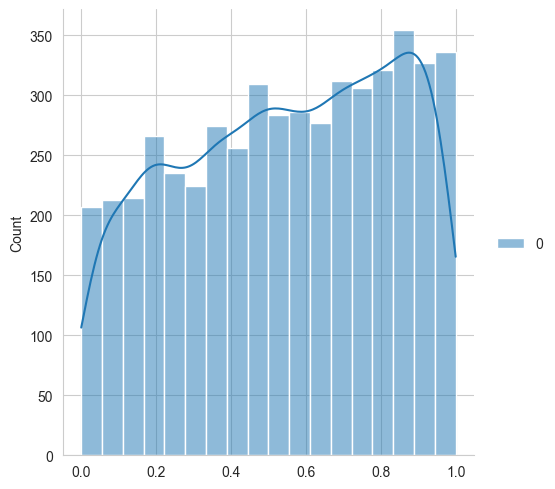

In [122]:
sns.displot(params_arr[:, 0], kde=True)

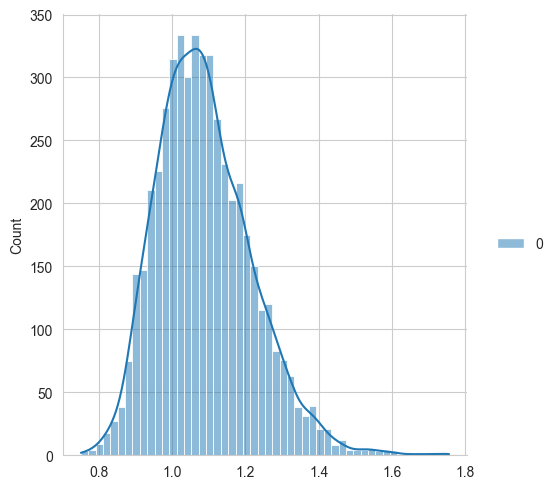

In [123]:
sns.displot(params_arr[:, 1], kde=True)

In [1]:
np.median(params_arr[:, 0]), params_arr[:, 0].std()

NameError: name 'np' is not defined

In [125]:
params_arr[:, 1].mean(), params_arr[:, 1].std()

(1.0888359048170624, 0.1294842966446059)

In [126]:
norms.min()

0.0

In [127]:
np.median(norms)

0.0